In [7]:
import pandas as pd
import matplotlib.pyplot as plt

data=pd.read_csv('iris1.csv')
data.isnull().sum()

sepal_len    0
sepal_wid    0
petal_len    0
petal_wid    0
class        0
dtype: int64

In [2]:
print(data.shape)
print(data.info())

(150, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sepal_len  150 non-null    float64
 1   sepal_wid  150 non-null    float64
 2   petal_len  150 non-null    float64
 3   petal_wid  150 non-null    float64
 4   class      150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None


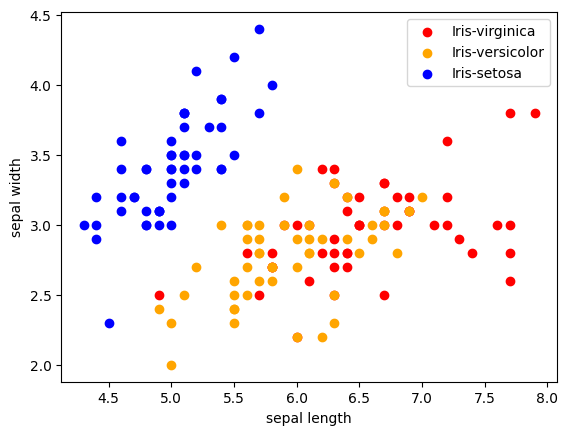

In [3]:
# scatter plot
colors=['red' , 'orange', 'blue']
species=['Iris-virginica','Iris-versicolor' ,'Iris-setosa']

for i in range(3):
    x=data[data['class'] ==species[i]]
    plt.scatter(x['sepal_len'], x['sepal_wid'] , c=colors[i] , label= species[i])
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

In [4]:
y = data['class']
y

0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
            ...      
145    Iris-virginica
146    Iris-virginica
147    Iris-virginica
148    Iris-virginica
149    Iris-virginica
Name: class, Length: 150, dtype: object

Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1 Score: 0.97


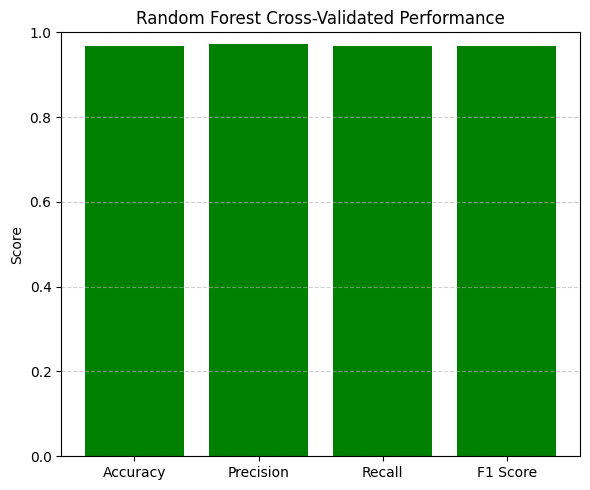

In [8]:
# Random Forest
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import math
import random

columns = ['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
label_map = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
data['class'] = data['class'].map(label_map)

# Utility: Entropy and Best Split
def entropy(y):
    total = len(y)
    counts = Counter(y)
    return -sum((c / total) * math.log2(c / total) for c in counts.values())

def best_split(data, feature_subset):
    base_entropy = entropy(data['class'])
    best_gain = 0
    best_feature, best_threshold = None, None

    for feature in feature_subset:
        values = sorted(data[feature].unique())
        for i in range(1, len(values)):
            threshold = (values[i - 1] + values[i]) / 2
            left = data[data[feature] <= threshold]
            right = data[data[feature] > threshold]
            if len(left) == 0 or len(right) == 0:
                continue
            info = (len(left) / len(data)) * entropy(left['class']) + (len(right) / len(data)) * entropy(right['class'])
            gain = base_entropy - info
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold
    return best_feature, best_threshold

# Tree Node and Tree Builder
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def build_tree(data, max_features):
    y = data['class']
    if len(set(y)) == 1:
        return Node(value=y.iloc[0])
    if data.shape[1] == 1:
        return Node(value=Counter(y).most_common(1)[0][0])

    feature_subset = random.sample(list(data.columns[:-1]), max_features)
    feature, threshold = best_split(data, feature_subset)
    if feature is None:
        return Node(value=Counter(y).most_common(1)[0][0])

    left_data = data[data[feature] <= threshold]
    right_data = data[data[feature] > threshold]
    left = build_tree(left_data, max_features)
    right = build_tree(right_data, max_features)
    return Node(feature, threshold, left, right)

def predict_tree(node, x):
    if node.value is not None:
        return node.value
    if x[node.feature] <= node.threshold:
        return predict_tree(node.left, x)
    else:
        return predict_tree(node.right, x)

# Random Forest
def bootstrap_sample(data):
    return data.sample(frac=1.0, replace=True)

def random_forest(train_data, n_trees=10, max_features=2):
    forest = []
    for _ in range(n_trees):
        sample = bootstrap_sample(train_data)
        tree = build_tree(sample, max_features)
        forest.append(tree)
    return forest

def predict_forest(forest, x_row):
    predictions = [predict_tree(tree, x_row) for tree in forest]
    return Counter(predictions).most_common(1)[0][0]

# Evaluation
def evaluate(y_true, y_pred):
    accuracy = sum(y1 == y2 for y1, y2 in zip(y_true, y_pred)) / len(y_true)
    precision_list, recall_list, f1_list = [], [], []
    labels = np.unique(y_true)

    for label in labels:
        TP = sum((y_true[i] == label and y_pred[i] == label) for i in range(len(y_true)))
        FP = sum((y_true[i] != label and y_pred[i] == label) for i in range(len(y_true)))
        FN = sum((y_true[i] == label and y_pred[i] != label) for i in range(len(y_true)))

        precision = TP / (TP + FP + 1e-6)
        recall = TP / (TP + FN + 1e-6)
        f1 = 2 * precision * recall / (precision + recall + 1e-6)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    return accuracy, np.mean(precision_list), np.mean(recall_list), np.mean(f1_list)

# K-Fold Cross-Validation
def k_fold_cross_validation(data, k=5):
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    fold_size = len(data) // k

    accs, precs, recs, f1s = [], [], [], []

    for i in range(k):
        test_idx = indices[i*fold_size:(i+1)*fold_size]
        train_idx = np.setdiff1d(indices, test_idx)

        train_data = data.iloc[train_idx].reset_index(drop=True)
        test_data = data.iloc[test_idx].reset_index(drop=True)

        forest = random_forest(train_data, n_trees=15, max_features=2)
        y_pred = [predict_forest(forest, row) for _, row in test_data.iterrows()]
        y_true = test_data['class'].tolist()

        acc, pre, rec, f1 = evaluate(y_true, y_pred)
        accs.append(acc)
        precs.append(pre)
        recs.append(rec)
        f1s.append(f1)

        # print(f"Fold {i+1}: Accuracy={acc:.2f}, Precision={pre:.2f}, Recall={rec:.2f}, F1 Score={f1:.2f}")

    return np.mean(accs), np.mean(precs), np.mean(recs), np.mean(f1s)

# Run CV
acc_rf, pre_rf, rec_rf, f1_rf = k_fold_cross_validation(data, k=5)


print(f"Accuracy: {acc_rf:.2f}")
print(f"Precision: {pre_rf:.2f}")
print(f"Recall: {rec_rf:.2f}")
print(f"F1 Score: {f1_rf:.2f}")

# Visualization
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
rf_scores = [acc_rf, pre_rf, rec_rf, f1_rf]

plt.figure(figsize=(6, 5))
plt.bar(labels, rf_scores, color='green')
plt.title('Random Forest Cross-Validated Performance')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
